Using device: cuda


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/50


Training: 100%|██████████| 54/54 [00:23<00:00,  2.26it/s]


Training Loss: 2.9557, Training Accuracy: 0.0888, Training Precision: 0.0818


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.85it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]


Validation Loss: 2.8434, Validation Accuracy: 0.1415, Validation Precision: 0.1654
Model terbaik disimpan.

Epoch 2/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:25<00:00,  2.24it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:25<00:00,  2.14it/s]


Training Loss: 2.6306, Training Accuracy: 0.2513, Training Precision: 0.2590


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.62it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Validation Loss: 2.6240, Validation Accuracy: 0.1671, Validation Precision: 0.2413
Model terbaik disimpan.

Epoch 3/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.11it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.05it/s]


Training Loss: 2.1204, Training Accuracy: 0.4777, Training Precision: 0.5135


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.17it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Validation Loss: 1.6525, Validation Accuracy: 0.6125, Validation Precision: 0.6906
Model terbaik disimpan.

Epoch 4/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.09it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.96it/s]


Training Loss: 1.6111, Training Accuracy: 0.6767, Training Precision: 0.7160


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.16it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Validation Loss: 0.9131, Validation Accuracy: 0.9026, Validation Precision: 0.9133
Model terbaik disimpan.

Epoch 5/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.16it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.02it/s]


Training Loss: 1.2104, Training Accuracy: 0.7539, Training Precision: 0.7869


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.40it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Validation Loss: 0.5792, Validation Accuracy: 0.9374, Validation Precision: 0.9440
Model terbaik disimpan.

Epoch 6/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.01it/s]


Training Loss: 0.9908, Training Accuracy: 0.7742, Training Precision: 0.8186


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.26it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Validation Loss: 0.3625, Validation Accuracy: 0.9652, Validation Precision: 0.9675
Model terbaik disimpan.

Epoch 7/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.00it/s]


Training Loss: 0.8220, Training Accuracy: 0.8056, Training Precision: 0.8417


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.24it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Validation Loss: 0.2548, Validation Accuracy: 0.9722, Validation Precision: 0.9741
Model terbaik disimpan.

Epoch 8/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.01it/s]


Training Loss: 0.8254, Training Accuracy: 0.7795, Training Precision: 0.8253


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.24it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Validation Loss: 0.2436, Validation Accuracy: 0.9536, Validation Precision: 0.9672
No improvement in validation accuracy for 1 epoch(s).

Epoch 9/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:26<00:00,  2.00it/s]


Training Loss: 0.8206, Training Accuracy: 0.7702, Training Precision: 0.8199


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.25it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Validation Loss: 0.1593, Validation Accuracy: 0.9745, Validation Precision: 0.9777
Model terbaik disimpan.

Epoch 10/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.12it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.00it/s]


Training Loss: 0.7286, Training Accuracy: 0.7998, Training Precision: 0.8436


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.27it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Validation Loss: 0.1154, Validation Accuracy: 0.9954, Validation Precision: 0.9954
Model terbaik disimpan.

Epoch 11/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.7374, Training Accuracy: 0.7882, Training Precision: 0.8368


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.27it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Validation Loss: 0.0818, Validation Accuracy: 1.0000, Validation Precision: 1.0000
Model terbaik disimpan.

Epoch 12/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.12it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.7266, Training Accuracy: 0.7870, Training Precision: 0.8362


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.25it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Validation Loss: 0.0864, Validation Accuracy: 0.9907, Validation Precision: 0.9911
No improvement in validation accuracy for 1 epoch(s).

Epoch 13/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.12it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.7167, Training Accuracy: 0.7899, Training Precision: 0.8387


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.24it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Validation Loss: 0.0623, Validation Accuracy: 0.9977, Validation Precision: 0.9978
No improvement in validation accuracy for 2 epoch(s).

Epoch 14/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.11it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.6528, Training Accuracy: 0.8114, Training Precision: 0.8544


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.23it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Validation Loss: 0.0737, Validation Accuracy: 0.9907, Validation Precision: 0.9911
No improvement in validation accuracy for 3 epoch(s).

Epoch 15/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.12it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.7014, Training Accuracy: 0.7922, Training Precision: 0.8504


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.22it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Validation Loss: 0.0491, Validation Accuracy: 0.9977, Validation Precision: 0.9978
No improvement in validation accuracy for 4 epoch(s).

Epoch 16/50


Training:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  2.11it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 54/54 [00:27<00:00,  1.99it/s]


Training Loss: 0.6824, Training Accuracy: 0.7992, Training Precision: 0.8425


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.24it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]
/tmp/ipykernel_30/1832991592.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untruste

Validation Loss: 0.0461, Validation Accuracy: 0.9954, Validation Precision: 0.9954
No improvement in validation accuracy for 5 epoch(s).

Early stopping triggered. Menghentikan pelatihan.


Validation:   0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  93%|█████████▎| 13/14 [00:02<00:00,  6.28it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]



Akurasi Validasi Terbaik: 1.0000, Presisi: 1.0000


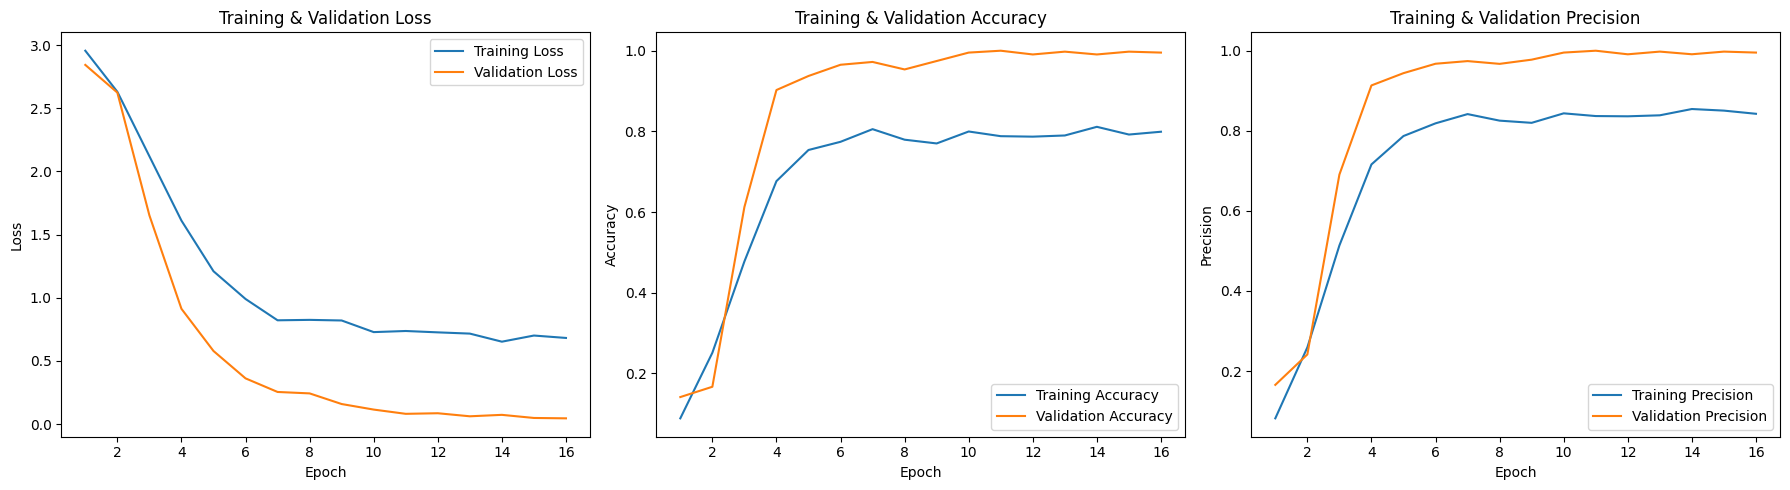

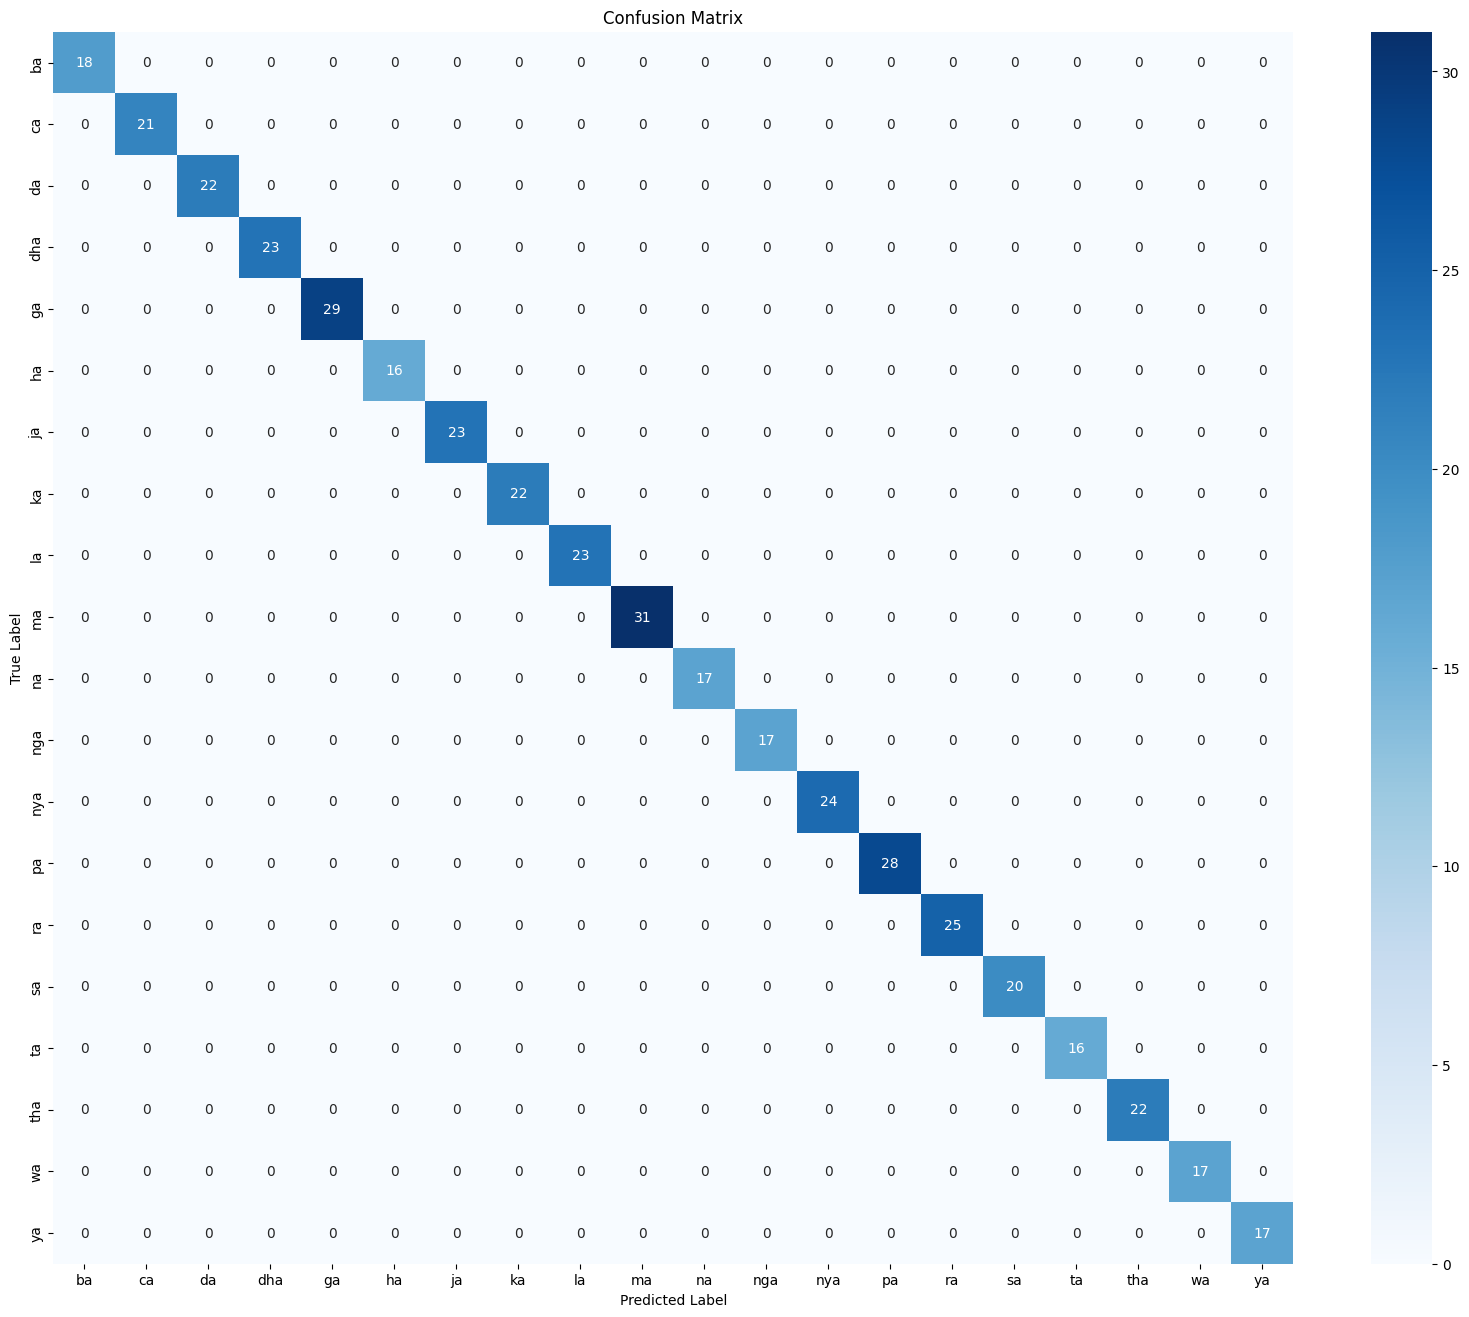

Classification Report:
              precision    recall  f1-score   support

          ba       1.00      1.00      1.00        18
          ca       1.00      1.00      1.00        21
          da       1.00      1.00      1.00        22
         dha       1.00      1.00      1.00        23
          ga       1.00      1.00      1.00        29
          ha       1.00      1.00      1.00        16
          ja       1.00      1.00      1.00        23
          ka       1.00      1.00      1.00        22
          la       1.00      1.00      1.00        23
          ma       1.00      1.00      1.00        31
          na       1.00      1.00      1.00        17
         nga       1.00      1.00      1.00        17
         nya       1.00      1.00      1.00        24
          pa       1.00      1.00      1.00        28
          ra       1.00      1.00      1.00        25
          sa       1.00      1.00      1.00        20
          ta       1.00      1.00      1.00        16
    

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


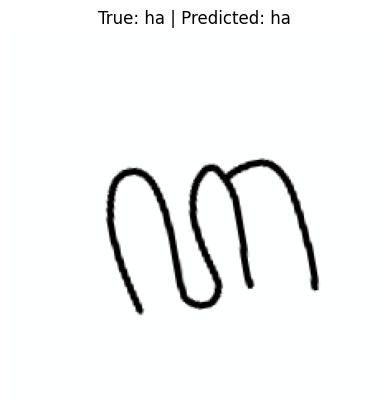

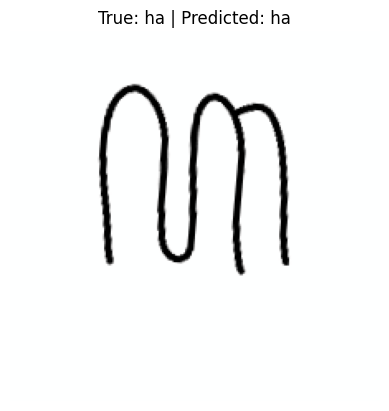

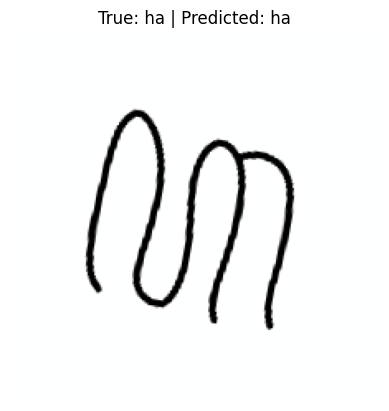

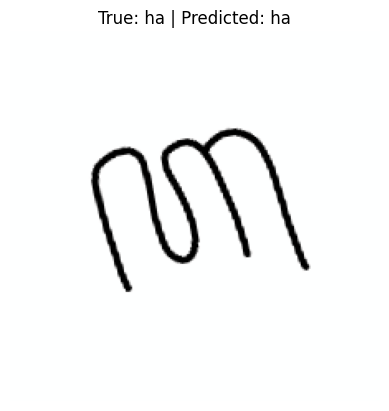

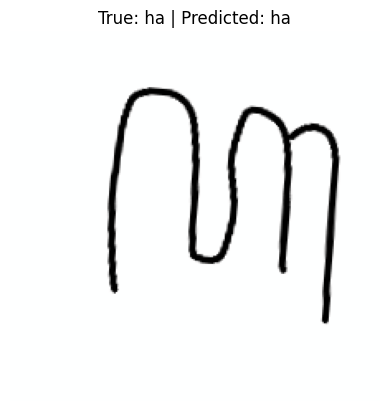

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import CvtForImageClassification, CvtConfig, AutoImageProcessor
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import numpy as np

# 3. Persiapan Dataset dan DataLoader

# Path dataset
data_dir = '/kaggle/input/d/phiard/aksara-jawa/v3/v3/train'  # Ganti dengan path dataset Anda jika berbeda

# Inisialisasi Image Processor dari pre-trained CvT
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

# Definisikan transformasi untuk pelatihan dengan augmentasi data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Definisikan transformasi untuk validasi tanpa augmentasi
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Muat dataset menggunakan ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Pastikan jumlah kelas sesuai
num_classes = 20
assert len(dataset.classes) == num_classes, f"Jumlah kelas harus {num_classes}, tetapi ditemukan {len(dataset.classes)} kelas."

# Bagi dataset menjadi train dan validation (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update transform untuk val_dataset
val_dataset.dataset.transform = val_transforms

# Definisikan DataLoader
batch_size = 32  # Sesuaikan dengan kapasitas GPU Anda
num_workers = 4  # Sesuaikan dengan CPU Anda

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# ### 4. Inisialisasi Model CvT Pre-trained

# Cek perangkat (GPU atau CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Muat konfigurasi CvT dan sesuaikan jumlah kelas
config = CvtConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = num_classes  # Sesuaikan jumlah label

# Inisialisasi model CvT untuk klasifikasi gambar dengan pre-trained weights
# Tambahkan ignore_mismatched_sizes=True untuk mengabaikan perbedaan ukuran layer classifier
model = CvtForImageClassification.from_pretrained(
    "microsoft/cvt-13", 
    config=config,
    ignore_mismatched_sizes=True
)

# Pindahkan model ke perangkat
model.to(device)

# ### 5. Definisi Optimizer dan Scheduler

# Definisikan optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total langkah pelatihan
epochs = 50  # Maksimum jumlah epoch, Early Stopping akan menghentikan lebih awal jika diperlukan
patience = 5  # Jumlah epoch tanpa peningkatan sebelum menghentikan pelatihan
total_steps = len(train_loader) * epochs

# Definisikan scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# ### 6. Definisi Fungsi Pelatihan dan Validasi

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, preds = torch.max(logits, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct.double() / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy.item(), precision

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            _, preds = torch.max(logits, dim=1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct.double() / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy.item(), precision, all_labels, all_preds

# ### 7. Pelatihan Model dengan Early Stopping

# Inisialisasi list untuk menyimpan metrik pelatihan
train_losses = []
train_accuracies = []
train_precisions = []
val_losses = []
val_accuracies = []
val_precisions = []

best_val_accuracy = 0.0
epochs_no_improve = 0
early_stop = False

for epoch in range(epochs):
    if early_stop:
        print("\nEarly stopping triggered. Menghentikan pelatihan.")
        break
    
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    train_loss, train_acc, train_prec = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_prec)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Precision: {train_prec:.4f}")
    
    val_loss, val_acc, val_prec, val_labels, val_preds = eval_epoch(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Precision: {val_prec:.4f}")
    
    # Cek apakah ada peningkatan akurasi validasi
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_cvt_model.pth')
        print("Model terbaik disimpan.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            early_stop = True

# ### 8. Memuat Model Terbaik dan Evaluasi Akhir

# Muat model terbaik
model.load_state_dict(torch.load('best_cvt_model.pth'))

# Evaluasi akhir pada data validasi
val_loss, val_acc, val_prec, val_labels, val_preds = eval_epoch(model, val_loader, device)
print(f"\nAkurasi Validasi Terbaik: {val_acc:.4f}, Presisi: {val_prec:.4f}")

# ### 9. Visualisasi Grafik Pelatihan

# Plot Loss
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Precision
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_precisions)+1), train_precisions, label='Training Precision')
plt.plot(range(1, len(val_precisions)+1), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training & Validation Precision')
plt.legend()

plt.tight_layout()
plt.show()

# ### 10. Menampilkan Confusion Matrix

# Menggunakan data dari evaluasi terakhir
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.classes, 
            yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ### 11. Menampilkan Classification Report

print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes, zero_division=0))

# ### 12. Hasil Prediksi Per Kelas

# Fungsi untuk menampilkan hasil prediksi per kelas
def show_predictions_per_class(model, dataloader, device, classes, target_class, num_samples=5):
    model.eval()
    samples_shown = 0
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            
            for i in range(len(labels)):
                if labels[i].item() == target_class:
                    image = inputs[i].cpu().permute(1, 2, 0).numpy()
                    # Denormalisasi
                    image = image * np.array(image_processor.image_std) + np.array(image_processor.image_mean)
                    image = np.clip(image, 0, 1)
                    
                    plt.imshow(image)
                    plt.title(f"True: {classes[labels[i].item()]} | Predicted: {classes[preds[i].item()]}")
                    plt.axis('off')
                    plt.show()
                    
                    samples_shown += 1
                    if samples_shown >= num_samples:
                        return

# Contoh: Menampilkan 5 prediksi dari kelas 'ha'
# Pastikan 'ha' adalah salah satu kelas dalam dataset Anda
target_class_name = 'ha'  # Ganti sesuai nama kelas Anda

if target_class_name in dataset.classes:
    target_class_index = dataset.class_to_idx[target_class_name]
    print(f"\nMenampilkan contoh prediksi untuk kelas: {target_class_name}")
    show_predictions_per_class(model, val_loader, device, dataset.classes, target_class_index, num_samples=5)
else:
    print(f"Kelas '{target_class_name}' tidak ditemukan dalam dataset.")

# ### 13. (Opsional) Menggunakan Model Terlatih untuk Prediksi pada Gambar Baru

# Berikut adalah contoh bagaimana Anda dapat menggunakan model terlatih untuk memprediksi kelas gambar baru.

# from PIL import Image
# import matplotlib.pyplot as plt

# # Path ke gambar baru
# image_path = '/path/to/your/image.jpg'  # Ganti dengan path gambar Anda

# # Buka dan proses gambar
# image = Image.open(image_path).convert('RGB')
# inputs = image_processor(images=image, return_tensors="pt")
# inputs = {k: v.to(device) for k, v in inputs.items()}

# # Lakukan prediksi
# model.eval()
# with torch.no_grad():
#     outputs = model(**inputs)
#     logits = outputs.logits
#     predicted_label = torch.argmax(logits, dim=1).item()

# # Tampilkan hasil
# print(f"Predicted label: {dataset.classes[predicted_label]}")

# # Tampilkan gambar
# plt.imshow(image)
# plt.title(f"Predicted: {dataset.classes[predicted_label]}")
# plt.axis('off')
# plt.show()
